In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import Model
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
x = np.load('/content/drive/MyDrive/Datasets/fold2/images.npy')
y = np.load('/content/drive/MyDrive/Datasets/fold2/types.npy')


In [ ]:
#encoding y
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y = onehot_encoded

[3 3 3 ... 5 5 5]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 0)


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(2018, 256, 256, 3) (2018, 19)
(505, 256, 256, 3) (505, 19)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state= 0)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1816, 256, 256, 3) (1816, 19)
(202, 256, 256, 3) (202, 19)
(505, 256, 256, 3) (505, 19)


**REsNet50**

In [ ]:
#@title Default title text


train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train)
val_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
val_generator.fit(x_val)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test)
#Initializing ResNet50
from tensorflow.keras.applications import ResNet50
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))
#model_resnet.summary()
from tensorflow.keras.optimizers import SGD
model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train ,y_train, epochs=40, validation_data =(x_val, y_val), verbose=1)
test_score = model_resnet.evaluate(x_test, y_test, verbose = 1) 


94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/40
57/57 [==============================] - 170s 3s/step - loss: 2.1643 - accuracy: 0.4141 - val_loss: 6.1874 - val_accuracy: 0.1832
Epoch 2/40
57/57 [==============================] - 165s 3s/step - loss: 1.5588 - accuracy: 0.5264 - val_loss: 4.8160 - val_accuracy: 0.2228
Epoch 3/40
57/57 [==============================] - 164s 3s/step - loss: 1.2902 - accuracy: 0.6178 - val_loss: 4.5099 - val_accuracy: 0.2921
Epoch 4/40
57/57 [==============================] - 162s 3s/step - loss: 1.0948 - accuracy: 0.6795 - val_loss: 2.3573 - val_accuracy: 0.3812
Epoch 5/40
57/57 [==============================] - 161s 3s/step - loss: 0.8412 - accuracy: 0.7533 - val_loss: 1.5297 - val_accuracy: 0.5594
Epoch 6/40
57/57 [==============================] - 163s 3s/step - loss: 0.6333 - accuracy: 0.8128 - val_loss: 2.3793 - val_accuracy: 0.3861
Epoch 7/40
57/57 [==============================] - 163s 3s/step - loss: 0.4553 - accurac

In [ ]:
model_resnet.save('resnet50 fold2.h5')

**Vgg19 model**

In [ ]:
#@title Default title text

from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, batch_size = 128, epochs = 50, verbose = 1, validation_data = (x_val, y_val))

	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	model.save('vgg19 fold1.h5')


run_test_harness()

80150528/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
15/15 [==============================] - 91s 6s/step - loss: 7.8457 - accuracy: 0.2621 - val_loss: 3.6787 - val_accuracy: 0.2723
Epoch 2/50
15/15 [==============================] - 89s 6s/step - loss: 2.2009 - accuracy: 0.4180 - val_loss: 2.8758 - val_accuracy: 0.2723
Epoch 3/50
15/15 [==============================] - 88s 6s/step - loss: 1.5880 - accuracy: 0.5198 - val_loss: 2.6920 - val_accuracy: 0.3218
Epoch 4/50
15/15 [==============================] - 88s 6s/step - loss: 1.2404 - accuracy: 0.6041 - val_loss: 2.6249 - val_accuracy: 0.3564
Epoch 5/50
15/15 [==============================] - 87s 6s/step - loss: 1.0250 - accuracy: 0.6652 - val_loss: 2.7223 - val_accuracy: 0.3861
Epoch 6/50
15/15 [==============================] - 87s 6s/step - loss: 0.8533 - accuracy: 0.7241 - val_loss: 2.7214 - val_accuracy: 0.3812
Epoch 7/50
15/15 [==============================] - 87s 6s/step - loss: 0.7119 - accuracy: 0.7748 - val_loss: 2.8424 - val_accuracy: 0.3663
Epoch 8/50
15/15 [==

**Vgg16**

In [ ]:
#@title Default title text

# from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data = (x_val, y_val))
	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	# save model
	model.save('vgg16 fold1.h5')


run_test_harness()

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
57/57 [==============================] - 73s 1s/step - loss: 4.4494 - accuracy: 0.3243 - val_loss: 2.3489 - val_accuracy: 0.3218
Epoch 2/50
57/57 [==============================] - 72s 1s/step - loss: 1.5107 - accuracy: 0.5215 - val_loss: 2.2214 - val_accuracy: 0.3762
Epoch 3/50
57/57 [==============================] - 72s 1s/step - loss: 1.1880 - accuracy: 0.6107 - val_loss: 2.2264 - val_accuracy: 0.4059
Epoch 4/50
57/57 [==============================] - 72s 1s/step - loss: 0.9576 - accuracy: 0.6806 - val_loss: 2.3677 - val_accuracy: 0.3812
Epoch 5/50
57/57 [==============================] - 72s 1s/step - loss: 0.7871 - accuracy: 0.7307 - val_loss: 2.4408 - val_accuracy: 0.3812
Epoch 6/50
57/57 [==============================] - 72s 1s/step - loss: 0.6389 - accuracy: 0.7847 - val_loss: 2.6667 - val_accuracy: 0.4010
Epoch 7/50
57/57 [==============================] - 72s 1s/step - loss: 0.5139 - accuracy: 0.8276 - val_loss: 2.7323 - val_accuracy: 0.3861
Epoch 8/50
57/57 [==

**DenseNet**

In [ ]:
#@title Default title text

import tensorflow as tf
base_model_denseNet= tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=y_train.shape[1],
    
)
#Adding layers to the ResNet50
model_dense=Sequential()
#Add the Dense layers along with activation and batch normalization
model_dense.add(base_model_denseNet)
model_dense.add(Flatten())
#Add the Dense layers along with activation and batch normalization
# model_dense.add(Dense(1024,activation=('relu'), input_dim=512))
model_dense.add(Dense(512,activation=('relu'))) 
model_dense.add(Dropout(.4))
model_dense.add(Dense(256,activation=('relu'))) 
model_dense.add(Dropout(.3))
model_dense.add(Dense(128,activation=('relu')))
model_dense.add(Dropout(.2))
model_dense.add(Dense(19,activation=('softmax')))

from tensorflow.keras.optimizers import SGD
model_dense.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
dense_net_history = model_dense.fit(x_train, y_train, epochs=40, validation_data = (x_val, y_val), verbose=1)
score = model_dense.evaluate(x_test, y_test, verbose= 1)

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/40
57/57 [==============================] - 667s 12s/step - loss: 3.0324 - accuracy: 0.2616 - val_loss: 2.3311 - val_accuracy: 0.2277
Epoch 2/40
57/57 [==============================] - 698s 12s/step - loss: 1.7505 - accuracy: 0.4532 - val_loss: 2.8971 - val_accuracy: 0.2277
Epoch 3/40
57/57 [==============================] - 691s 12s/step - loss: 1.6434 - accuracy: 0.4857 - val_loss: 2.3826 - val_accuracy: 0.2426
Epoch 4/40
57/57 [==============================] - 685s 12s/step - loss: 1.5080 - accuracy: 0.5347 - val_loss: 2.5506 - val_accuracy: 0.3317
Epoch 5/40
57/57 [==============================] - 668s 12s/step - loss: 1.4322 - accuracy: 0.5606 - val_loss: 1.9752 - val_accuracy: 0.3861
Epoch 6/40
57/57 [==============================] - 686s 12s/step - loss: 1.3404 - accuracy: 0.5920 - val_loss: 1.7907 - val_accuracy: 0.4802
Epoch 7/40
57/57 [==============================] - 683s 12s/step - loss: 1.2620 - 

In [ ]:
#First Spliting the dataset into three parts
x_train1, x_train3, y_train1, y_train3 = train_test_split(x,y, test_size=.33, random_state=0)
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train1, y_train1, test_size=.50, random_state=0)

In [ ]:
#Now printing the shape and size of three parts
print(x_train1.shape, y_train1.shape)
print(x_train2.shape, y_train2.shape)
print(x_train3.shape, y_train3.shape)

(845, 256, 256, 3) (845, 19)
(845, 256, 256, 3) (845, 19)
(833, 256, 256, 3) (833, 19)


In [ ]:
# spliting x_train1 and y_train1 into train , validation and test set
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1, y_train1, test_size=.2, random_state=1)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=.1, random_state=1)

#printing the shape
print("................printing the sahpe..............")
print(x_train1.shape, y_train1.shape)
print(x_val1.shape, y_val1.shape)
print(x_test1.shape, y_test1.shape)

................printing the sahpe..............
(608, 256, 256, 3) (608, 19)
(68, 256, 256, 3) (68, 19)
(169, 256, 256, 3) (169, 19)


In [ ]:
# spliting x_train2 and y_train2 into train , validation and test set
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=.1, random_state=1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train2, y_train2, test_size=.2, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)
print(x_test2.shape, y_test2.shape)

printing the sahpe..............
(608, 256, 256, 3) (608, 19)
(85, 256, 256, 3) (85, 19)
(152, 256, 256, 3) (152, 19)


In [ ]:
# spliting x_train3 and y_train3 into train , validation and test set
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size=.1, random_state=1)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_train3, y_train3, test_size=.2, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train3.shape, y_train3.shape)
print(x_val3.shape, y_val3.shape)
print(x_test3.shape, y_test3.shape)

printing the sahpe..............
(599, 256, 256, 3) (599, 19)
(84, 256, 256, 3) (84, 19)
(150, 256, 256, 3) (150, 19)


**ResNet50 Model for ensembling**

In [ ]:
#@title Default title text
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
val_generator.fit(x_val1)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test1)


#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))

#Summary of ResNet50 Model
#model_resnet.summary()

model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train1 ,y_train1, epochs=50, validation_data =(x_val1, y_val1), verbose=1)
score = model_resnet.evaluate(x_test1, y_test1, verbose=1)
model_resnet.save('resNet50-fold2.h5')

Epoch 1/50
19/19 [==============================] - 61s 3s/step - loss: 2.9474 - accuracy: 0.2829 - val_loss: 3.4724 - val_accuracy: 0.1176
Epoch 2/50
19/19 [==============================] - 55s 3s/step - loss: 2.0075 - accuracy: 0.4490 - val_loss: 3.8932 - val_accuracy: 0.1765
Epoch 3/50
19/19 [==============================] - 55s 3s/step - loss: 1.5491 - accuracy: 0.5444 - val_loss: 3.4591 - val_accuracy: 0.1765
Epoch 4/50
19/19 [==============================] - 55s 3s/step - loss: 1.2445 - accuracy: 0.6102 - val_loss: 4.4795 - val_accuracy: 0.1765
Epoch 5/50
19/19 [==============================] - 56s 3s/step - loss: 1.0740 - accuracy: 0.6743 - val_loss: 3.2280 - val_accuracy: 0.2353
Epoch 6/50
19/19 [==============================] - 56s 3s/step - loss: 0.8996 - accuracy: 0.7204 - val_loss: 2.9470 - val_accuracy: 0.2353
Epoch 7/50
19/19 [==============================] - 56s 3s/step - loss: 0.6301 - accuracy: 0.8158 - val_loss: 2.1595 - val_accuracy: 0.3676
Epoch 8/50
19/19 [==

**VGG19 for ensembling**

In [ ]:
#@title Default title text


from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train2, y_train2, batch_size = 128, epochs = 45, verbose = 1, validation_data = (x_val2, y_val2))

	# evaluate model
	acc = model.evaluate(x_test2, y_test2, verbose=1)
	
	model.save('vgg19-fold2.h5')


run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/45
5/5 [==============================] - 34s 7s/step - loss: 12.3507 - accuracy: 0.1217 - val_loss: 7.6900 - val_accuracy: 0.3176
Epoch 2/45
5/5 [==============================] - 31s 6s/step - loss: 5.5678 - accuracy: 0.2780 - val_loss: 5.2541 - val_accuracy: 0.2941
Epoch 3/45
5/5 [==============================] - 31s 6s/step - loss: 2.4794 - accuracy: 0.4918 - val_loss: 3.3990 - val_accuracy: 0.3412
Epoch 4/45
5/5 [==============================] - 31s 6s/step - loss: 1.3841 - accuracy: 0.6086 - val_loss: 3.0883 - val_accuracy: 0.3176
Epoch 5/45
5/5 [==============================] - 31s 6s/step - loss: 0.9809 - accuracy: 0.7089 - val_loss: 3.0014 - val_accuracy: 0.3765
Epoch 6/45
5/5 [==============================] - 31s 6s/step - loss: 0.6860 - accuracy: 0.8076 - val_loss: 3.0007 - val_accuracy: 0.4000
Epoch 7/45
5/5 [==============================] - 31s 6s/step - loss: 0.4711 - accuracy: 0.8865 - val_loss: 2.9602 - val_accuracy: 0.4118
Epoch 8/45
5/5 [=================

**Model VGG16 using for ensemble**

In [ ]:
#@title Default title text


from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train3, y_train3, epochs=45, verbose=1, validation_data = (x_val3, y_val3))
	# evaluate model
	acc = model.evaluate(x_test3, y_test3, verbose=1)
	
	# save model
	model.save('vgg16-fold2.h5')


run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/45
19/19 [==============================] - 26s 1s/step - loss: 8.2376 - accuracy: 0.2521 - val_loss: 3.1649 - val_accuracy: 0.3452
Epoch 2/45
19/19 [==============================] - 24s 1s/step - loss: 1.4842 - accuracy: 0.5492 - val_loss: 3.1037 - val_accuracy: 0.3929
Epoch 3/45
19/19 [==============================] - 24s 1s/step - loss: 0.8714 - accuracy: 0.7062 - val_loss: 2.8886 - val_accuracy: 0.4167
Epoch 4/45
19/19 [==============================] - 24s 1s/step - loss: 0.6021 - accuracy: 0.7830 - val_loss: 3.1026 - val_accuracy: 0.4405
Epoch 5/45
19/19 [==============================] - 24s 1s/step - loss: 0.4002 - accuracy: 0.8631 - val_loss: 3.3108 - val_accuracy: 0.4405
Epoch 6/45
19/19 [==============================] - 24s 1s/step - loss: 0.2891 - accuracy: 0.9048 - val_loss: 3.4415 - val_accuracy: 0.4643
Epoch 7/45
19/19 [==============================] - 24s 1s/step - loss: 0.1990 - accuracy: 0.9449 - val_loss: 3.5593 - val_accuracy: 0.4524
Epoch 8/45
19/19 [==

In [ ]:
#@title Sequential model 1
# #Model 1

# #Defining the Convolutional Neural Network
# model1 = Sequential()

# model1.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(64, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(128, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Flatten())

# model1.add(Dense(128, activation = 'relu'))
# model1.add(Dense(19, activation = 'softmax'))


# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model1.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model1.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history1 = model1.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model1.save('model 1 fold1 epoch 10.hdf5')

In [ ]:
#@title sequential model 2
# model2 = Sequential()

# model2.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model2.add(Conv2D(32, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(128, (3, 3), activation='relu'))
# model2.add(Conv2D(25, (1,1)))

# model2.add(Flatten())

# model2.add(Dense(19, activation = 'softmax'))

# model2.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model2.summary()

# history2 = model2.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model2.save('model2 fold1 epoch 10.hdf5')

In [ ]:
#@title Sequential model 3

# model3 = Sequential()

# model3.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Conv2D(64, (3, 3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Flatten())

# model3.add(Dense(19, activation = 'softmax'))

# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model3.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model3.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history3 = model3.fit(x_train2, y_train2, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model3.save('model3 fold3 epoch 10.hdf5')


**Ensembling all the three models (VGG16, Vgg19, RestNet50)**


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [ ]:
model1 = load_model('resNet50-fold2.h5')
model2 = load_model('vgg19-fold2.h5')
model3 = load_model('vgg16-fold2.h5')


In [ ]:
models = [model1, model2, model3] 


In [ ]:
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)


In [ ]:
accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis= 1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))


ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model2 =  0.4316831683168317
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.7920792079207921


In [ ]:
#Weighted average ensemble
models = [model1, model2,model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.3, .1,.6] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)

In [ ]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model2 =  0.4316831683168317
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.7920792079207921
Accuracy Score for weighted average ensemble =  0.8356435643564356


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2], " and w3=", max_acc_row[3])         


Max accuracy of  0.3  obained with w1= 0.1  w2= 0.4  and w3= 85.14851485148515


In [ ]:
class_names =['Adrenal', 'Bile duct', 'Bladder', 'Breast', 'Colon', 'Cervix', 'Esophagus', 'Head&Neck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Testis', 'Stomach', 'Thyroid', 'Uterus']

Predicted Label:  Liver
True Label:  Liver


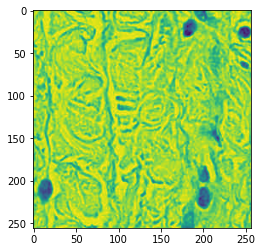

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.3, .1,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling resNet50 and vgg19**

In [ ]:
model1 = load_model('resNet50-fold2.h5')
model2 = load_model('vgg19-fold2.h5')
models = [model1, model2] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model1, model2] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model2 =  0.4316831683168317
Accuracy Score for average ensemble =  0.5762376237623762
Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model2 =  0.4316831683168317
Accuracy Score for average ensemble =  0.5762376237623762
Accuracy Score for weighted average ensemble =  0.601980198019802


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2])         


Max accuracy of  0.1  obained with w1= 0.0  w2= 61.584158415841586


Predicted Label:  Head&Neck
True Label:  Head&Neck


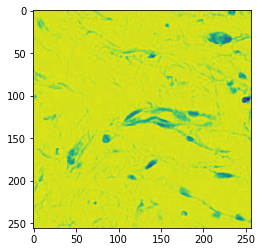

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model2]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling resnet50 and vgg16**

In [ ]:
model1 = load_model('resNet50-fold2.h5')
model3 = load_model('vgg16-fold2.h5')
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction3 = model3.predict(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.8356435643564356
Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.8356435643564356
Accuracy Score for weighted average ensemble =  0.691089108910891


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w3=", max_acc_row[2])         


Max accuracy of  0.3  obained with w1= 0.4  w3= 84.55445544554455


In [ ]:
#Weighted average ensemble
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.2,.8] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6158415841584158
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.8356435643564356
Accuracy Score for weighted average ensemble =  0.8336633663366336


Predicted Label:  Breast
True Label:  Breast


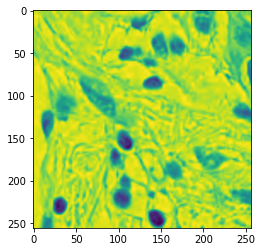

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling vgg19 & vgg16**

In [ ]:
model2 = load_model('vgg19-fold2.h5')
model3 = load_model('vgg16-fold2.h5')
models = [model2, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis=1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model2 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model2, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model2 =  0.6158415841584158
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.8118811881188119
Accuracy Score for model2 =  0.4316831683168317
Accuracy Score for model3 =  0.8297029702970297
Accuracy Score for average ensemble =  0.8118811881188119
Accuracy Score for weighted average ensemble =  0.8297029702970297


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w2=", max_acc_row[1],
      " w3=", max_acc_row[2])         


Max accuracy of  0.3  obained with w2= 0.4  w3= 83.16831683168317


Predicted Label:  Pancreatic
True Label:  Pancreatic


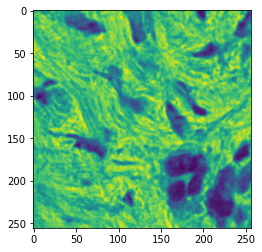

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])

